# Capstone Project - Week 1
## Function 8: 8D Optimization Challenge
### Initial Data Exploration and Analysis

**Date:** January 27, 2026

**Objective:** Maximize F8 using Bayesian Optimization

**Approach:** 
- Load and explore initial 8D samples
- Fit Gaussian Process surrogate model
- Use Expected Improvement for next point selection
- Look at UCB next point selection also

## Section 1: Import Required Libraries

In [65]:
# Core scientific computing libraries
import numpy as np
import matplotlib.pyplot as plt

# Gaussian Process regression and optimization
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern
from scipy.stats import norm
from scipy.optimize import minimize

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print(f'Libraries loaded successfully for F8 (8D)')

Libraries loaded successfully for F8 (8D)


## Section 2: Load Initial Data

Loading Week 1 initial samples for Function 8

In [66]:
# Define file paths for F8
INPUT_FILE = 'f8_initial_inputs.npy'   # Shape: (n_samples, 8)
OUTPUT_FILE = 'f8_initial_outputs.npy' # Shape: (n_samples,)

In [67]:
# Load data
X = np.load(INPUT_FILE)  # Input matrix
Y = np.load(OUTPUT_FILE) # Output vector

# Display data information
print('F8 Data Loaded:')
print(f'  Input shape:  {X.shape}')
print(f'  Output shape: {Y.shape}')
print(f'  Dimensions:   {X.shape[1]}D')
print(f'  Samples:      {len(X)}')

F8 Data Loaded:
  Input shape:  (40, 8)
  Output shape: (40,)
  Dimensions:   8D
  Samples:      40


## Section 3: Exploratory Data Analysis

In [68]:
# Ensure proper data format
X = np.atleast_2d(X)
Y = Y.ravel()

print('='*70)
print('FUNCTION 8 - INITIAL DATA ANALYSIS')
print('='*70)

# Output statistics
print(f'\nOutput Statistics:')
print(f'  Maximum:  {Y.max():.6f}')
print(f'  Minimum:  {Y.min():.6f}')
print(f'  Mean:     {Y.mean():.6f}')
print(f'  Median:   {np.median(Y):.6f}')
print(f'  Std Dev:  {Y.std():.6f}')
print(f'  Range:    {Y.max() - Y.min():.6f}')

# Find best point
best_idx = np.argmax(Y)
best_value = Y[best_idx]
best_point = X[best_idx]

print(f'\n🎯 Best Point Found (Initial Sampling):')
print(f'  Value:    {best_value:.6f}')
print(f'  Location: {best_point}')

# Input space coverage
print(f'\nInput Space Coverage:')
for i in range(X.shape[1]):
    print(f'  X{i+1}: [{X[:, i].min():.4f}, {X[:, i].max():.4f}]')

FUNCTION 8 - INITIAL DATA ANALYSIS

Output Statistics:
  Maximum:  9.598482
  Minimum:  5.592193
  Mean:     7.815274
  Median:   7.889150
  Std Dev:  0.946903
  Range:    4.006289

🎯 Best Point Found (Initial Sampling):
  Value:    9.598482
  Location: [0.05644741 0.06595555 0.02292868 0.03878647 0.40393544 0.80105533
 0.48830701 0.89308498]

Input Space Coverage:
  X1: [0.0091, 0.9859]
  X2: [0.0034, 0.9740]
  X3: [0.0229, 0.9989]
  X4: [0.0090, 0.9030]
  X5: [0.0096, 0.9869]
  X6: [0.0221, 0.9902]
  X7: [0.0359, 0.9929]
  X8: [0.0420, 0.9888]


In [69]:
##now print all the data
print("Input function 8 data: \n",np.load(INPUT_FILE))
print("Output function 8 data: \n",np.load(OUTPUT_FILE))

Input function 8 data: 
 [[0.60499445 0.29221502 0.90845275 0.35550624 0.20166872 0.57533801
  0.31031095 0.73428138]
 [0.17800696 0.56622265 0.99486184 0.21032501 0.32015266 0.70790879
  0.63538449 0.10713163]
 [0.00907698 0.81162615 0.52052036 0.07568668 0.26511183 0.09165169
  0.59241515 0.36732026]
 [0.50602816 0.65373012 0.36341078 0.17798105 0.0937283  0.19742533
  0.7558269  0.29247234]
 [0.35990926 0.24907568 0.49599717 0.70921498 0.11498719 0.28920692
  0.55729515 0.59388173]
 [0.77881834 0.0034195  0.33798313 0.51952778 0.82090699 0.53724669
  0.5513471  0.66003209]
 [0.90864932 0.0622497  0.23825955 0.76660355 0.13233596 0.99024381
  0.68806782 0.74249594]
 [0.58637144 0.88073573 0.74502075 0.54603485 0.00964888 0.74899176
  0.23090707 0.09791562]
 [0.76113733 0.85467239 0.38212433 0.33735198 0.68970832 0.30985305
  0.63137968 0.04195607]
 [0.9849332  0.69950626 0.9988855  0.18014846 0.58014315 0.23108719
  0.49082694 0.31368272]
 [0.11207131 0.43773566 0.59659878 0.59277563

In [70]:
print(f"Loaded {X.shape[0]} points in {X.shape[1]}D" )
print(f"Current best : {Y.max():.6e} at {X[Y.argmax()]}")  # 
X = np.atleast_2d(X)  # Make sure X is aleays 4d
Y = Y.ravel() #  forces Y to be 1 d flat


Loaded 40 points in 8D
Current best : 9.598482e+00 at [0.05644741 0.06595555 0.02292868 0.03878647 0.40393544 0.80105533
 0.48830701 0.89308498]


In [71]:
##Section 2: Fit surrogate for function 1

## Section 4: Gaussian Process Model

Fitting a GP surrogate model to learn the function landscape

In [72]:
kernel  = ConstantKernel(1.0,constant_value_bounds=(1e-10,1e10)) * RBF(length_scale=0.3,  length_scale_bounds=(0.01,10.0)) \
+ WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10,10000.0))

In [73]:
gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 30, normalize_y=False, random_state=42)

In [74]:
gp.fit(X,Y)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=0.3) + WhiteKernel(noise_level=1e-05),
                         n_restarts_optimizer=30, random_state=42)

In [75]:
##Section 3  Define the acquision function

## Section 6: Visualization

Visualizing the optimization landscape and strategy

In [76]:
# create grid for plotting

In [77]:
n_points = 100          # lower than 1000 because 5D → memory & time
x1 = np.linspace(X[:,0].min(), X[:,0].max(), n_points)

x_plot = np.column_stack([
    x1,
    np.full(n_points, X[:,1].mean()),
    np.full(n_points, X[:,2].mean()),
    np.full(n_points, X[:,3].mean()),
    np.full(n_points, X[:,4].mean()),
    np.full(n_points, X[:,5].mean()),
    np.full(n_points, X[:,6].mean()),
    np.full(n_points, X[:,7].mean())
])

In [78]:
# Get GP Predictions 

In [79]:
mv, sigma = gp.predict(x_plot, return_std=True)

## Section 5: Acquisition Function Optimization

Using Expected Improvement to select next sampling point

In [80]:
# Calculate expected improvement

In [81]:
y_best = Y.max() # best observed value so far

In [82]:
# EI CALCULATION

In [83]:
with np.errstate(divide='warn'):
    improvement = mv - y_best
    Z = improvement / sigma
    EI = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    EI[sigma == 0.0] = 0.0

In [84]:
# FIND NEXT SAMPLING POINT 

In [85]:
x_next = x_plot[np.argmax(EI)]

In [86]:
print(f"Best current value :{y_best:.6f} at x{X[Y.argmax()][0]:.6f}")

Best current value :9.598482 at x0.056447


In [87]:
print(f"EI data gives next point to sample: x_next = {x_next[0]:.6f},{x_next[1]:.6f}")

EI data gives next point to sample: x_next = 0.009077,0.472150


In [88]:
#Now Plot

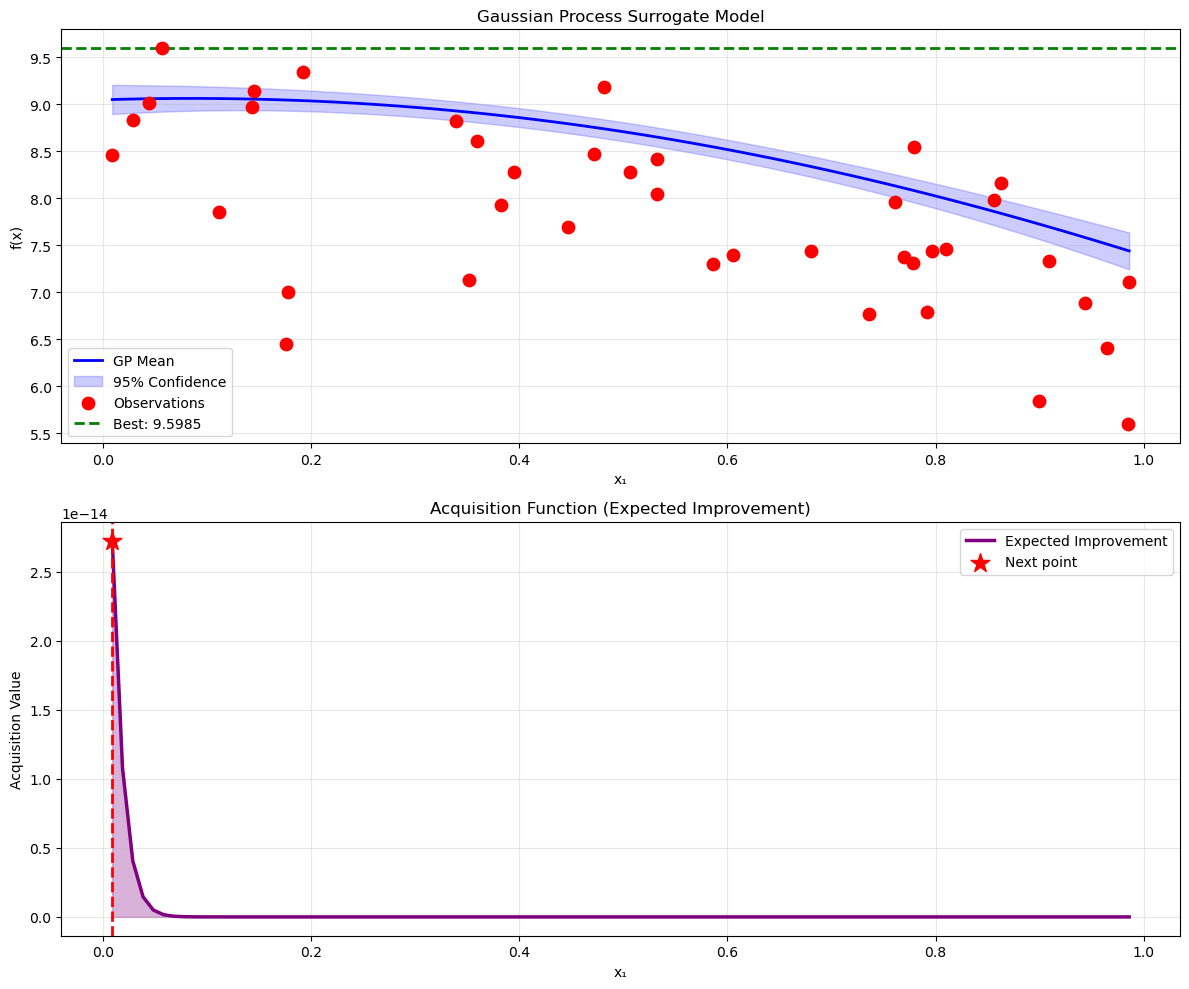

In [89]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10)) 
# Top plot: GP surrogate 
ax1.plot(x_plot[:, 0], mv, 'b-', label='GP Mean', linewidth=2) 
ax1.fill_between(x_plot[:, 0], mv - 1.96*sigma, mv + 1.96*sigma, alpha=0.2, color='blue', label='95% Confidence') 
ax1.scatter(X[:, 0], Y, c='red', s=80, zorder=10, label='Observations') 
ax1.axhline(y=y_best, color='green', linestyle='--', linewidth=2, label=f'Best: {y_best:.4f}') 
ax1.set_xlabel('x₁') 
ax1.set_ylabel('f(x)') 
ax1.set_title('Gaussian Process Surrogate Model') 
ax1.legend() 
ax1.grid(True, alpha=0.3) 
# Bottom plot: Acquisition function (EI)
ax2.plot(x_plot[:, 0], EI, 'purple', linewidth=2.5, label='Expected Improvement') 
ax2.axvline(x=x_next[0], color='red', linestyle='--', linewidth=2) 
ax2.scatter(x_next[0], np.max(EI), c='red', s=200, marker='*', zorder=10, label=f'Next point') 
ax2.fill_between(x_plot[:, 0], 0, EI, alpha=0.3, color='purple') 
ax2.set_xlabel('x₁') 
ax2.set_ylabel('Acquisition Value') 
ax2.set_title('Acquisition Function (Expected Improvement)') 
ax2.legend() 
ax2.grid(True, alpha=0.3) 
plt.tight_layout() 
plt.show()

In [90]:
##Now look for the UCB

In [91]:
# UCB Acquisition Function - Create 8D prediction grid
kappa = 2.0  # Exploration parameter

# Create grid for UCB (X1 varies, others fixed at mean)
n_points = 300
x1_ucb = np.linspace(X[:, 0].min(), X[:, 0].max(), n_points)

x_plot_ucb = np.column_stack([
    x1_ucb,
    np.full(n_points, X[:, 1].mean()),
    np.full(n_points, X[:, 2].mean()),
    np.full(n_points, X[:, 3].mean()),
    np.full(n_points, X[:, 4].mean()),
    np.full(n_points, X[:, 5].mean()),
    np.full(n_points, X[:, 6].mean()),
    np.full(n_points, X[:, 7].mean()),
])

print(f'UCB grid created: {x_plot_ucb.shape}')
print(f'Grid is 8D: X1 varies, others fixed at their means')


UCB grid created: (300, 8)
Grid is 8D: X1 varies, others fixed at their means


In [92]:
##Find Next sampling point

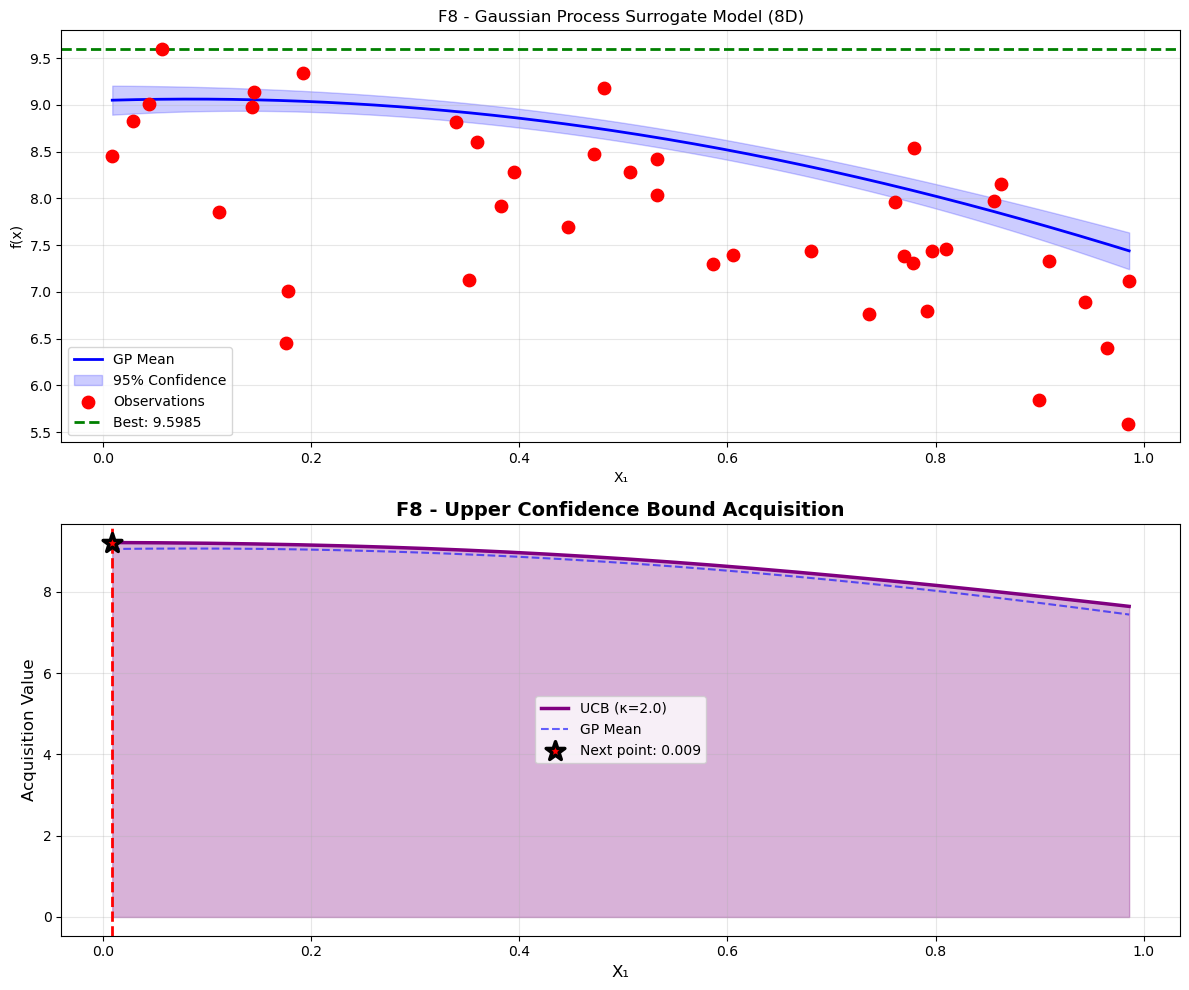


UCB suggests next point for F8: [0.00907698 0.47214964 0.51596951 0.43044885 0.46895067 0.46012561
 0.57919576 0.5067203 ]


In [93]:
# Generate predictions on UCB grid
mv_ucb, sigma_ucb = gp.predict(x_plot_ucb, return_std=True)
UCB = mv_ucb + kappa * sigma_ucb

# Find best UCB point
x_next_idx = np.argmax(UCB)
x_next_ucb = x_plot_ucb[x_next_idx]
y_best_ucb = Y.max()

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top plot: GP surrogate
ax1.plot(x_plot_ucb[:, 0], mv_ucb, 'b-', label='GP Mean', linewidth=2)
ax1.fill_between(x_plot_ucb[:, 0], mv_ucb - 1.96*sigma_ucb, mv_ucb + 1.96*sigma_ucb,
                 alpha=0.2, color='blue', label='95% Confidence')
ax1.scatter(X[:, 0], Y, c='red', s=80, zorder=10, label='Observations')
ax1.axhline(y=y_best_ucb, color='green', linestyle='--', linewidth=2,
            label=f'Best: {y_best_ucb:.4f}')
ax1.set_xlabel('X₁')
ax1.set_ylabel('f(x)')
ax1.set_title('F8 - Gaussian Process Surrogate Model (8D)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom plot: UCB acquisition function
ax2.plot(x_plot_ucb[:, 0], UCB, 'purple', linewidth=2.5,
         label=f'UCB (κ={kappa})')
ax2.plot(x_plot_ucb[:, 0], mv_ucb, 'b--', linewidth=1.5, alpha=0.6,
         label='GP Mean')
ax2.axvline(x=x_next_ucb[0], color='red', linestyle='--', linewidth=2)
ax2.scatter(x_next_ucb[0], np.max(UCB), c='red', s=200, marker='*',
            zorder=10, edgecolors='black', linewidth=2.5,
            label=f'Next point: {x_next_ucb[0]:.3f}')
ax2.fill_between(x_plot_ucb[:, 0], 0, UCB, alpha=0.3, color='purple')
ax2.set_xlabel('X₁', fontsize=12)
ax2.set_ylabel('Acquisition Value', fontsize=12)
ax2.set_title('F8 - Upper Confidence Bound Acquisition', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\nUCB suggests next point for F8: {x_next_ucb}')


In [94]:
# Now print the next best sampling points for UCB and EI

In [95]:
print("\n" + "="*60) 
print("QUERY SUBMISSION") 
print("="*60) 
print(f"UCB data gives next point to sample for Function 8: x_next_ucb = {x_next_ucb[0]:.6f}, {x_next_ucb[1]:.6f}, {x_next_ucb[2]:.6f},{x_next_ucb[3]:.6f},{x_next_ucb[4]:.6f},{x_next_ucb[5]:.6f},{x_next_ucb[6]:.6f},{x_next_ucb[7]:.6f}") 
print(f"EI  data gives next point to sample for Function 8: x_next = {x_next[0]:.6f}, {x_next[1]:.6f},{x_next[2]:.6f},{x_next[3]:.6f},{x_next[4]:.6f},{x_next[5]:.6f},{x_next[6]:.6f},{x_next[7]:.6f}")
print("="*60)


QUERY SUBMISSION
UCB data gives next point to sample for Function 8: x_next_ucb = 0.009077, 0.472150, 0.515970,0.430449,0.468951,0.460126,0.579196,0.506720
EI  data gives next point to sample for Function 8: x_next = 0.009077, 0.472150,0.515970,0.430449,0.468951,0.460126,0.579196,0.506720


In [96]:
 # generate random data pointsfrom scipy.stats import normdef expected_improvement(X_new,gp,y_best,xi=0.01):     mv,sigma= gp.predict(X_new,return_std=True)     sigma = np.maximum(sigma,1e-10)     imp = mv-y_best -xi     Z = imp/sigma     ei = imp*norm.cdf(Z)+sigma * norm.pdf(Z)     ei[sigma < 1e-10] =0.0     return eikernel  = ConstantKernel(1.0,constant_value_bounds=(1e-10,1e10)) * RBF(length_scale=0.3,  length_scale_bounds=(0.01,10.0)) \+ WhiteKernel(noise_level=1e-10, noise_level_bounds=(1e-12,1e-2))gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 30, normalize_y=False, random_state=42)gp.fit(X,Y)n_candidates = 5000candidates = np.random.uniform(0,1,size=(n_candidates,8))#compute acquision curve on candidatesacquisition_type = "UCB"#acquisition_type = "EI"best_idx= Noneif acquisition_type == "EI":    y_best = Y.max()    ei_values = expected_improvement(candidates,gp,y_best=y_best,xi=0.01)    best_idx=np.argmax(ei_values)    print("Using Expected Improvement (EI)")elif  acquisition_type == "UCB":      mv,sigma=gp.predict(candidates,return_std=True)      ucb_values = mv+2.0*sigma      best_idx = np.argmax(ucb_values)      print("Using Upper Confidence Bounds (UCB)")else:    raise ValueError("Invalid acquision type")if acquisition_type == "UCB":    x_next = candidates[best_idx]    x_next = np.clip(x_next,0.0,1.0)    print("Random data: Next point from random candidates:",x_next)print("Random Data: GP fitted. Learned kernal :",gp.kernel_)